In [1]:
import numpy as np
import mat73
import matplotlib.pyplot as plt

# Data loading and preprocessing

In [2]:
data_file = "/home/yoel/Downloads/CRE181_150401_data.mat"

In [3]:
data_dict = mat73.loadmat(data_file)

In [4]:
data_dict["data"].keys()

dict_keys(['pos_ts', 'pos_x', 'pos_y', 'session', 'spikes_ts', 'tetrodes'])

In [5]:
session_index = 0

time = data_dict["data"]["pos_ts"][session_index]

pos_x = data_dict["data"]["pos_x"][session_index]

pos_y = data_dict["data"]["pos_y"][session_index]

spikes = data_dict["data"]["spikes_ts"][session_index] # spike times detected in all 91 tetrodes

tetrodes = data_dict["data"]["tetrodes"][session_index] # session array with 91 tetrode labels per array

bin_width = 5 # 5 sec bin width for no good reason

n_bins = np.floor((spikes[0][-1] - spikes[0][0]) / bin_width).astype(int)

In [6]:
def avg_pos(pos_x, pos_y, bin_edgs):
    time_wins = np.array([(bin_edgs[j], bin_edgs[j+1]) for j in range(len(bin_edgs)-1)])
    
    time_inds= [np.logical_and(time_wins[j, 0] < time, time < time_wins[j, 1]) 
                for j in range(len(bin_edgs)-1)]

    avg_pos_x = np.array([pos_x[ind].mean() for ind in time_inds])

    avg_pos_y = np.array([pos_y[ind].mean() for ind in time_inds])
                         
    return avg_pos_x, avg_pos_y

In [7]:
def get_spikes(spikes, pos_x, pos_y, n_bins):
    spike_counts, bin_edges = [], []
    avg_x_tm, avg_y_tm = [], []
    
    for spk in spikes:
        spk_cnt, spk_tm = np.histogram(spk, n_bins)
        
        spike_counts.append(spk_cnt)
        
        x, y = avg_pos(pos_x, pos_y, spk_tm)
        
        bin_edges.append(spk_tm)
        
        avg_x_tm.append(x)
        
        avg_y_tm.append(y)
    
    spike_counts = np.vstack(spike_counts).T # time points by tetrodes
    
    avg_x = np.vstack(avg_x_tm).T
    
    avg_y = np.vstack(avg_y_tm).T
    
    return spike_counts, avg_x, avg_y 

In [13]:
S, x, y = get_spikes(spikes, pos_x, pos_y, n_bins)
Y = np.hstack([x.mean(1)[:, None], y.mean(1)[:, None]])

Text(0, 0.5, 'pos_y')

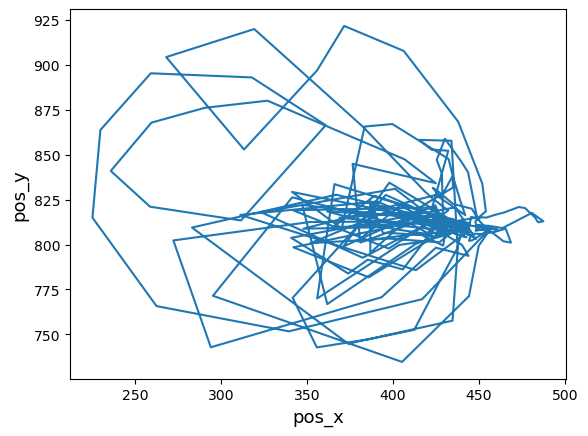

In [23]:
fs = 13
plt.plot(Y[:, 0], Y[:, 1])
plt.xlabel("pos_x", fontsize=fs)
plt.ylabel("pos_y", fontsize=fs)

In [11]:
S # spikes per tetrode

array([[ 2, 32,  3, ...,  3,  3,  8],
       [ 0,  7,  0, ...,  0,  1,  0],
       [ 1,  4,  0, ...,  0,  5,  0],
       ...,
       [ 0,  0,  1, ...,  1,  1,  0],
       [ 0,  1,  0, ...,  0,  2,  0],
       [ 2,  4, 50, ...,  1,  3,  3]])

# Decoding position given spikeing data

$$P(position | spikes) = \frac{p(spikes|position) p(position)}{p(spikes)}$$